In [1]:
from math import ceil
from keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras import backend as K
from keras.models import load_model

from keras_ssd7 import build_model
from keras_ssd_loss import SSDLoss
from ssd_box_encode_decode_utils import SSDBoxEncoder, decode_y, greedy_nms
from ssd_batch_generator import BatchGenerator

Using TensorFlow backend.


In [2]:
### Set up the model

# 1: Set some necessary parameters

img_height = 300 # Height of the input images
img_width = 480 # Width of the input images
img_channels = 3 # Number of color channels of the input images
n_classes = 2 # Number of classes including the background class
min_scale = 0.1 # The scaling factor for the smallest anchor boxes
max_scale = 0.9 # The scaling factor for the largest anchor boxes
scales = [0.08, 0.16, 0.32, 0.64, 0.96] # An explicit list of anchor box scaling factors. If this is passed, it will override `min_scale` and `max_scale`.
aspect_ratios = [0.5, 1.0, 2.0] # The list of aspect ratios for the anchor boxes
two_boxes_for_ar1 = True # Whether or not you want to generate two anchor boxes for aspect ratio 1
limit_boxes = True # Whether or not you want to limit the boxes to lie entirely within the image boundaries
variances = [0.1, 0.1, 0.2, 0.2] # The list of variances by which the encoded target coordinates are scaled
coords = 'centroids' # Whether the box coordinates to be used should be in the 'centroids' or 'minmax' format, see documentation

# 2: Build the Keras model (and possibly load some trained weights)

K.clear_session() # Clear previous models from memory.
# The output `classifier_sizes` is needed below to set up `SSDBoxEncoder`
model, classifier_sizes = build_model(image_size=(img_height, img_width, img_channels),
                                      n_classes=n_classes,
                                      min_scale=min_scale,
                                      max_scale=max_scale,
                                      scales=scales,
                                      aspect_ratios_global=aspect_ratios,
                                      aspect_ratios_per_layer=None,
                                      two_boxes_for_ar1=two_boxes_for_ar1,
                                      limit_boxes=limit_boxes,
                                      variances=variances,
                                      coords=coords)
model.load_weights('./model_test_weights.h5')
#model = load_model('./model_0.h5')

In [3]:
### Set up training

batch_size = 32

# 3: Instantiate an Adam optimizer and the SSD loss function and compile the model

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=5e-05)

ssd_loss = SSDLoss(neg_pos_ratio=3, n_neg_min=0, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

# 4: Instantiate an encoder that can encode ground truth labels into the format needed by the SSD loss function 

ssd_box_encoder = SSDBoxEncoder(img_height=img_height,
                                img_width=img_width,
                                n_classes=n_classes, 
                                classifier_sizes=classifier_sizes,
                                min_scale=min_scale,
                                max_scale=max_scale,
                                scales=scales,
                                aspect_ratios_global=aspect_ratios,
                                aspect_ratios_per_layer=None,
                                two_boxes_for_ar1=two_boxes_for_ar1,
                                limit_boxes=limit_boxes,
                                variances=variances,
                                pos_iou_threshold=0.5,
                                neg_iou_threshold=0.2,
                                coords=coords)

# 5: Create the batch generator

batch_generator = BatchGenerator(images_path='./data/',
                                 labels_path='./data/labels.csv',
                                 n_classes=n_classes)

train_generator = batch_generator.generate(batch_size=batch_size,
                                           train=True,
                                           ssd_box_encoder=ssd_box_encoder,
                                           crop=False,
                                           resize=False,
                                           gray=False,
                                           equalize=False,
                                           brightness=(0.5, 2, 0.5),
                                           flip=0.5,
                                           translate=((5, 50), (3, 30), 0.5),
                                           scale=(0.75, 1.3, 0.5),
                                           limit_boxes=True,
                                           include_thresh=0.4,
                                           diagnostics=False)

n_samples = batch_generator.get_n_samples()

In [5]:
### Run training

# 6: Run training

epochs = 10

history = model.fit_generator(generator = train_generator,
                              steps_per_epoch = ceil(n_samples/batch_size),
                              epochs = epochs,
                              callbacks = [ModelCheckpoint('./model_test_weights_epoch{epoch:02d}_loss{loss:.4f}.h5',
                                                           monitor='loss',
                                                           verbose=1,
                                                           save_best_only=True,
                                                           save_weights_only=True,
                                                           mode='auto',
                                                           period=1),
                                           EarlyStopping(monitor='loss',
                                                         min_delta=0.001,
                                                         patience=2),
                                           ReduceLROnPlateau(monitor='loss',
                                                             factor=0.5,
                                                             patience=0,
                                                             epsilon=0.001,
                                                             cooldown=0)])

model_name = 'model_test'
model.save('./{}.h5'.format(model_name))
model.save_weights('./{}_weights.h5'.format(model_name))

print()
print("Model saved as {}.h5".format(model_name))
print("Weights also saved separately as {}_weights.h5".format(model_name))
print()

Epoch 1/10
684/684 [==============================] - 297s - loss: 0.1984   
Epoch 2/10
684/684 [==============================] - 297s - loss: 0.1612   
Epoch 3/10
684/684 [==============================] - 295s - loss: 0.1471   
Epoch 4/10
684/684 [==============================] - 293s - loss: 0.1382   
Epoch 5/10
684/684 [==============================] - 292s - loss: 0.1325   
Epoch 6/10
 27/684 [>.............................] - ETA: 288s - loss: 0.1321

KeyboardInterrupt: 

In [4]:
### Make predictions

# 1: Create a generator to provide samples

predict_generator = batch_generator.generate(batch_size=1,
                                             train=False,
                                             crop=False,
                                             resize=False,
                                             gray=False,
                                             equalize=False,
                                             brightness=False,
                                             flip=False,
                                             translate=False,
                                             scale=False,
                                             limit_boxes=True,
                                             include_thresh=0.4,
                                             diagnostics=False)

In [46]:
X, y_true = next(predict_generator)

In [47]:
y_pred = model.predict(X)

In [48]:
import numpy as np
from matplotlib import pyplot as plt

%matplotlib inline

In [49]:
print(y_pred.shape)

y_pred_converted = np.copy(y_pred[:,:,-12:-6]) # Slice out the four offset predictions plus one element where we'll write the class IDs in the next step
y_pred_converted[:,:,0] = np.argmax(y_pred[:,:,:-12], axis=-1)

print(np.sum(y_pred_converted[0,:,0]))

np.set_printoptions(suppress=True, precision=3)
print(y_pred[y_pred[:,:,1] > 0.5])

(1, 10316, 14)
55.0
[[   0.135    0.865    0.79     1.107   -0.685   -3.906   78.621  141.429
    24.      24.       0.1      0.1      0.1      0.1  ]
 [   0.276    0.724    0.54     1.648   -2.626    0.372   78.621  141.429
    33.941   16.971    0.1      0.1      0.1      0.1  ]
 [   0.16     0.84    -0.464    0.676   -1.488   -4.245   86.897  141.429
    24.      24.       0.1      0.1      0.1      0.1  ]
 [   0.375    0.625   -0.889    1.243   -3.224    0.243   86.897  141.429
    33.941   16.971    0.1      0.1      0.1      0.1  ]
 [   0.341    0.659    0.55     0.298   -3.492   -5.055   95.172  141.429
    24.      24.       0.1      0.1      0.1      0.1  ]
 [   0.195    0.805    0.404    0.01    -2.596   -5.082  103.448  141.429
    24.      24.       0.1      0.1      0.1      0.1  ]
 [   0.39     0.61    -0.027   -0.249   -2.668   -5.017  111.724  141.429
    24.      24.       0.1      0.1      0.1      0.1  ]
 [   0.482    0.518    0.557    0.188    0.076   -0.579  434.48

In [50]:
print(y_true[0])

[[  0  83 104 229   1]
 [ 69  97 134 156   1]
 [101 117 137 150   1]
 [146 261 119 225   1]
 [310 323 143 152   1]
 [319 441 133 205   1]
 [428 479 143 166   1]]


In [51]:
y_true_encoded = ssd_box_encoder.encode_y(y_true)

print(y_true_encoded[y_true_encoded[:,:,1] == 1].shape)
print(y_true_encoded[y_true_encoded[:,:,1] == 1])

(33, 14)
[[   0.       1.       1.825    1.488    1.542   -0.87    78.621  141.429
    24.      24.       0.1      0.1      0.1      0.1  ]
 [   0.       1.       1.29     2.104   -1.924    2.596   78.621  141.429
    33.941   16.971    0.1      0.1      0.1      0.1  ]
 [   0.       1.      -1.624    1.488    1.542   -0.87    86.897  141.429
    24.      24.       0.1      0.1      0.1      0.1  ]
 [   0.       1.      -1.148    1.052   -1.924   -4.336   86.897  141.429
    33.941   33.941    0.1      0.1      0.1      0.1  ]
 [   0.       1.      -1.148    2.104   -1.924    2.596   86.897  141.429
    33.941   16.971    0.1      0.1      0.1      0.1  ]
 [   0.       1.      -1.135    0.863   -4.055   -6.131  111.724  141.429
    24.      24.       0.1      0.1      0.1      0.1  ]
 [   0.       1.      -0.884    2.53    -6.131   -9.808  318.621  141.429
    24.      24.       0.1      0.1      0.1      0.1  ]
 [   0.       1.      -1.624   -2.083    1.542   -0.87    86.897  150.
   

In [52]:
y_true_decoded = decode_y(y_true_encoded, confidence_thresh=0.5, coords='centroids')

print(y_true_decoded)

[array([[  69.,   97.,  134.,  156.,    1.,    1.],
       [  69.,   97.,  134.,  156.,    1.,    1.],
       [  69.,   97.,  134.,  156.,    1.,    1.],
       [  69.,   97.,  134.,  156.,    1.,    1.],
       [  69.,   97.,  134.,  156.,    1.,    1.],
       [ 101.,  117.,  137.,  150.,    1.,    1.],
       [ 310.,  323.,  143.,  152.,    1.,    1.],
       [  69.,   97.,  134.,  156.,    1.,    1.],
       [  69.,   97.,  134.,  156.,    1.,    1.],
       [ 428.,  479.,  143.,  166.,    1.,    1.],
       [ 428.,  479.,  143.,  166.,    1.,    1.],
       [ 428.,  479.,  143.,  166.,    1.,    1.],
       [ 428.,  479.,  143.,  166.,    1.,    1.],
       [ 428.,  479.,  143.,  166.,    1.,    1.],
       [ 428.,  479.,  143.,  166.,    1.,    1.],
       [  -0.,   83.,  104.,  229.,    1.,    1.],
       [   0.,   83.,  104.,  229.,    1.,    1.],
       [   0.,   83.,  104.,  229.,    1.,    1.],
       [   0.,   83.,  104.,  229.,    1.,    1.],
       [   0.,   83.,  104.,  

In [59]:
y_pred_decoded = decode_y(y_pred, confidence_thresh=0.7)

In [60]:
print(y_pred_decoded)

[array([[  69.312,   91.723,  135.965,  152.205,    1.   ,    0.865],
       [  67.402,   93.504,  135.418,  153.031,    1.   ,    0.724],
       [  75.443,   96.125,  135.201,  150.899,    1.   ,    0.84 ],
       [  95.162,  113.673,  134.233,  148.671,    1.   ,    0.805],
       [ 319.521,  403.874,  132.23 ,  198.185,    1.   ,    0.935],
       [ 319.059,  417.109,  137.524,  199.057,    1.   ,    0.968],
       [ 329.604,  433.329,  135.814,  195.137,    1.   ,    0.936],
       [ 347.942,  450.134,  132.069,  192.907,    1.   ,    0.906],
       [ 369.453,  461.724,  128.844,  190.853,    1.   ,    0.868],
       [ 317.881,  403.462,  129.032,  204.225,    1.   ,    0.853],
       [ 318.742,  420.959,  129.114,  206.789,    1.   ,    0.802],
       [  -4.957,   98.473,   68.656,  188.583,    1.   ,    0.722],
       [   0.051,   73.571,   98.956,  206.179,    1.   ,    0.797],
       [   0.461,   83.918,  105.003,  211.507,    1.   ,    0.927],
       [   4.619,   90.118,  103.

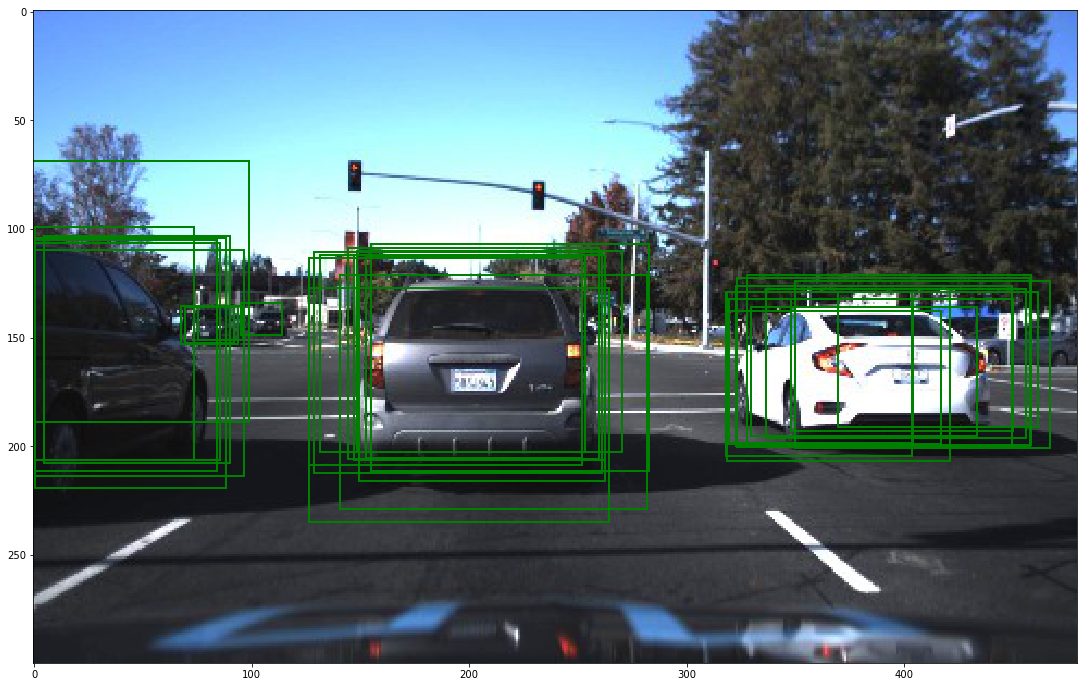

In [61]:
plt.figure(figsize=(20,12))
plt.imshow(X[0])

current_axis = plt.gca()

for box in y_pred_decoded[0]:
    current_axis.add_patch(plt.Rectangle((box[0], box[2]), box[1]-box[0], box[3]-box[2], color='green', fill=False, linewidth=2))  

In [62]:
y_pred_decoded_nms = greedy_nms(y_pred_decoded, iou_threshold=0.45)

In [63]:
class_dict = ['background', 'car', 'truck', 'pedestrian', 'bicyclist', 'light']

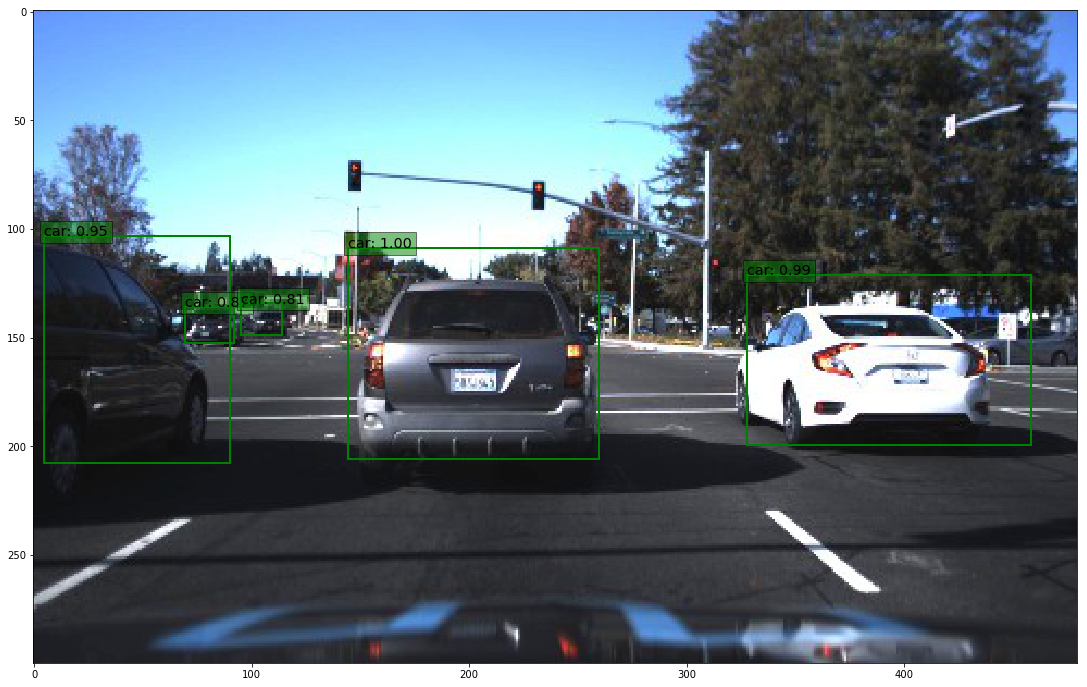

In [64]:
plt.figure(figsize=(20,12))
plt.imshow(X[0])

current_axis = plt.gca()

for box in y_pred_decoded_nms[0]:
    label = '{}: {:.2f}'.format(class_dict[int(box[-2])], box[-1])
    current_axis.add_patch(plt.Rectangle((box[0], box[2]), box[1]-box[0], box[3]-box[2], color='green', fill=False, linewidth=2))
    current_axis.text(box[0], box[2], label, size='x-large', bbox={'facecolor':'green', 'alpha':0.5})

In [17]:
variances = 0.2

print(np.any(np.array(variances) == 0))

False


In [18]:
print(list(variances))

TypeError: 'float' object is not iterable